In [1]:
# install need libraly and packages
!pip3 install pandas


  Using cached https://files.pythonhosted.org/packages/bb/71/8f53bdbcbc67c912b888b40def255767e475402e9df64050019149b1a943/pandas-1.0.3-cp36-cp36m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/e7/f9/f0b53f88060247251bf481fa6ea62cd0d25bf1b11a87888e53ce5b7c8ad2/pytz-2019.3-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/07/08/a549ba8b061005bb629b76adc000f3caaaf881028b963c2e18f811c6edc1/numpy-1.18.2-cp36-cp36m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/d4/70/d60450c3dd48ef87586924207ae8907090de0b306af2bce5d134d78615cb/python_dateutil-2.8.1-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/65/eb/1f97cb97bfc2390a276969c6fae16075da282f5058082d4cb10c6c5c1dba/six-1.14.0-py2.py3-none-any.whl


In [86]:
from __future__ import print_function

import pandas as pd
import numpy as np
from scipy.stats import ttest_ind, ttest_ind_from_stats
from scipy.special import stdtr

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 8]
%matplotlib inline

from datetime import datetime

In [3]:
# задать папку с файлами для обработки
path_ab_test = 'ab_test.tsv'
path_ab_test_res = 'ab_test.txt'

In [4]:
# read file a/b test result
df_ab_ctr = pd.read_csv(path_ab_test
                     ,encoding='cp1251'
                     , sep='\t'
                    ).fillna('') # замена пустых значений


df_ab_ctr.sample(2)

,search_id,search_date,clicks,group
2433,-2731449668054081775,2017-11-23,0,2
7178,-4235262577669278056,2017-11-22,0,3


In [5]:
df_ab_ctr.describe()

,search_id,clicks,group
count,9.662000e+03,9662.000000,9662.000000
mean,5.127190e+16,0.534568,2.503001
std,5.327594e+18,0.909413,0.500017
min,-9.220836e+18,0.000000,2.000000
25%,-4.578733e+18,0.000000,2.000000
50%,1.348137e+17,0.000000,3.000000
75%,4.576849e+18,1.000000,3.000000
max,9.220794e+18,15.000000,3.000000


In [6]:
# преобразование даты в UNIX формат
df_ab_ctr['search_date'] = pd.to_datetime(df_ab_ctr['search_date'])

df_ab_ctr.head()

,search_id,search_date,clicks,group
0,-3136706724385003188,2017-11-23,0,2
1,-3139609516900744687,2017-11-22,0,2
2,-776473245209166820,2017-11-22,0,2
3,2254608150971607405,2017-11-25,1,2
4,2397168305001145852,2017-11-24,0,2


In [7]:
# определяем тествовый период
df_ab_ctr['search_date'].describe()

count                    9662
unique                      4
top       2017-11-23 00:00:00
freq                     3455
first     2017-11-22 00:00:00
last      2017-11-25 00:00:00
Name: search_date, dtype: object

Для проверки равенства средних значений по выборке используют t-критерий Стьюдента.
Нулевая гипотеза в данном случае следущая - средние значения по двум выборкам равны,
альтернативная - значения не равны.

-----------------------

Для того чтобы понять, можем ли мы отвергнуть или принять нулевую гипотезу, 
нам надо посмотреть на значение p-value. 
Обычно *p-value 
берут равным 0,05 (уровень значимости 0,95) 
или 0,01 (уровень значимости 0,9). Чем выше уровень значимости (и меньше Р-значение), тем достовернее результаты.

разделю датасет на 2 датафрейма в соответствии с группой, далее по принципу 2 выборочного критерия для независимых выборок.
Просчитаем статистику с помощью метода ttest_ind

In [47]:
# разделение на группы
df_group_3 = df_ab_ctr[df_ab_ctr['group']==3]
df_group_2 = df_ab_ctr[df_ab_ctr['group']==2]

# проверка по структуре
df_group_2.shape, df_group_3.shape 

((4802, 4), (4860, 4))

In [59]:
print("group_mean:  group 2 = %g || group 3 = %g" % (df_group_2['clicks'].mean()
                                       , df_group_3['clicks'].mean()))

group_mean:  group 2 = 0.55706 || group 3 = 0.512346


In [48]:
# возмём равное число записей для 2 датафреймов

statist , p_value = ttest_ind(df_group_2['clicks'].sample(n=4800)
              , df_group_3['clicks'].sample(n=4800)
            , equal_var=False
             )

print("ttest_ind:  statist = %g  p_value = %g" % (statist, p_value))

ttest_ind:            statist = 2.41203  p_value = 0.0158824


как результат
- при уровне значимости 0,9 мы имеем значение pvalue больше 0,01 - поэтому мы отвергаем альтернативную гипотезу
- при уровне значимости 0,95 мы имеем значение pvalue меньше 0,05 - поэтому мы отвергаем нулевую гипотезу, что средние равны.

и соответственно расчитанное среднее значение для группы 2 не случайная величина.

**Хотя срок проведения А/В теста составлял только 4 дня, что могло быть недостаточных для более полной ситуации. Так же принимаю за условие, что тест проводится за обычных условий и на него не вляют дополнительные факторы (например, промо-кампании)**

# Для  визуализации по дням

In [91]:
# просчет суммы кликов в разбивке по дню и тест.группе
df_clicks = pd.pivot_table(df_ab_ctr, 
                   index=['group','search_date'], 
                   values=['clicks'],
                   aggfunc=np.sum)
df_clicks

clicks
group search_date        
2     2017-11-22      939
      2017-11-23      980
      2017-11-24      573
      2017-11-25      183
3     2017-11-22      937
      2017-11-23      884
      2017-11-24      535
      2017-11-25      134

In [90]:
# просчет к-ства показов в разбивке по дню и тест.группе
df_view = pd.pivot_table(df_ab_ctr, 
                     index=['group','search_date'], 
                     values='search_id',
                     aggfunc=len)
df_view

search_id
group search_date           
2     2017-11-22        1663
      2017-11-23        1755
      2017-11-24        1084
      2017-11-25         300
3     2017-11-22        1706
      2017-11-23        1700
      2017-11-24        1143
      2017-11-25         311

In [92]:
# объединение данные по кликам и показам
pivot = pd.concat([df_clicks,df_view],axis=1)
pivot['CTR'] = round(pivot['clicks'].div(pivot['search_id']) * 100, 2)

pivot.rename(columns={'search_id': 'cnt_view', 'clicks': 'sum_clicks'}, inplace=True)
pivot

sum_clicks  cnt_view    CTR
group search_date                             
2     2017-11-22          939      1663  56.46
      2017-11-23          980      1755  55.84
      2017-11-24          573      1084  52.86
      2017-11-25          183       300  61.00
3     2017-11-22          937      1706  54.92
      2017-11-23          884      1700  52.00
      2017-11-24          535      1143  46.81
      2017-11-25          134       311  43.09

In [165]:
# описательная статистика по каждой из групп.
"""
можно видеть, что распределение не нормальное, т.к. среднее, медиана не совпадают. 
Среднее значение для к-сва просмотров и кликов находится в I квартиле, скос - влево.
"""
pivot[['sum_clicks', 'cnt_view', 'CTR']].loc[2].describe(), pivot[['sum_clicks', 'cnt_view', 'CTR']].loc[3].describe()

(       sum_clicks     cnt_view        CTR
 count    4.000000     4.000000   4.000000
 mean   668.750000  1200.500000  56.540000
 std    371.946569   669.788275   3.363054
 min    183.000000   300.000000  52.860000
 25%    475.500000   888.000000  55.095000
 50%    756.000000  1373.500000  56.150000
 75%    949.250000  1686.000000  57.595000
 max    980.000000  1755.000000  61.000000,
        sum_clicks     cnt_view        CTR
 count     4.00000     4.000000   4.000000
 mean    622.50000  1215.000000  49.205000
 std     371.29548   657.952886   5.278968
 min     134.00000   311.000000  43.090000
 25%     434.75000   935.000000  45.880000
 50%     709.50000  1421.500000  49.405000
 75%     897.25000  1701.500000  52.730000
 max     937.00000  1706.000000  54.920000)

In [153]:
def name_plot(group):
    data = pivot[['sum_clicks', 'cnt_view']].loc[group]
    
    x = np.linspace(0, 20, 1000)
    plt.plot(data.index, data.values)


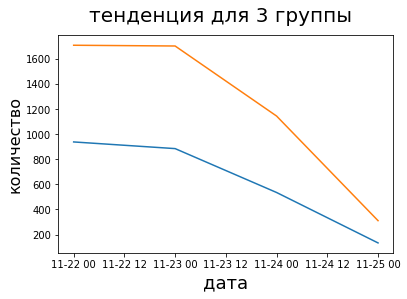

In [154]:
fig=plt.figure()
fig.suptitle('тенденция для 3 группы', fontsize=20)
plt.xlabel('дата', fontsize=18)
plt.ylabel('количество', fontsize=16)


name_plot(3)

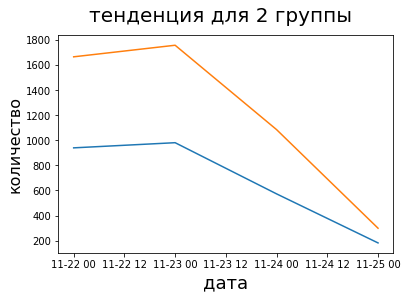

In [155]:
fig=plt.figure()
fig.suptitle('тенденция для 2 группы', fontsize=20)
plt.xlabel('дата', fontsize=18)
plt.ylabel('количество', fontsize=16)

name_plot(2)

для 2 группы 23-11-207 наблюдался определённый пик в показах и кликах. Но если смотреть на динамику, то падание показов стремительно 

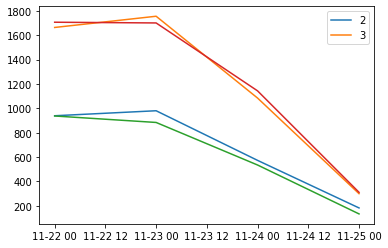

In [147]:
groups = [2, 3]

for group in groups:
    name_plot(group)
 
plt.legend(groups, loc="upper right")